In [109]:
import sys

In [110]:
! echo $HOSTNAME

d9d4d6ec916d


In [111]:
#put these paths at the end, so the system python packages of the same name have precedence

In [112]:
sys.path.append('/global/common/cori/software/neon/1.3.0')

In [113]:
sys.path.append('/global/common/cori/software/neon/1.3.0/.venv/lib/python2.7/site-packages/')

In [114]:
sys.path;

In [115]:
import numpy as np

In [116]:
__author__ = 'racah'
import os
import pickle
import sys
from neon.util.argparser import NeonArgparser

import h5py
import matplotlib
from sklearn.manifold import TSNE
import numpy as np
matplotlib.use('agg')
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from conv_ae import ConvAe
from vis.viz import Viz
from util.helper_fxns import adjust_train_val_test_sizes


from util.data_loaders import load_dayabay_conv

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [117]:
# 1) Primary AD           10000 or 1
# 2) Delayed AD response  01000 or 2
# 3) Muon decay           00100 or 3
# 4) Flasher              00010 or 4
# 5) Other (background noise) 00001 or 5

In [118]:
#neon makes you set things up with command line args, so here we set all the defaults
def setup_parser():
        # parse the command line arguments
        parser = NeonArgparser(__doc__)
        #main data file
        parser.add_argument('--h5file')
        
        #whether you are doing test or just train and val
        parser.add_argument('--test')
        
        parser.add_argument('--learn_rate')
        
        #hidden layer dimension for bottle neck of autoencoder
        parser.add_argument('--bneck_width')
        
        #how many iterations of tsne
        parser.add_argument('--max_tsne_iter')
        
        parser.set_defaults(batch_size=128,
                            h5file='/project/projectdirs/dasrepo/single_20000.h5',
                            
                            #take a snapshot every n epochs where n is value fo serialize
                            serialize=2, 
                            
                            #how many epochs
                            epochs=100, 
                            learn_rate=0.0001, 
                            
                            #where to save serialized weights for a model snapshot 
                            model_file=False,
                            
                            #how frequently to log validation data
                            eval_freq=1, 
                            test=False, 
                            
                            #where to save any results
                            save_path='./results/model_files/conv-ae2',
                            
                            #these flags are for doing the preprocessing geometrical tricks 
                            wrap_pad_trick=False, 
                            cylinder_local_trick=False, 
                            
                            bneck_width=10, 
                            max_tsne_iter=500)

        args = parser.parse_args()
        
        #convert strings to floats and ints
        args.learn_rate = float(args.learn_rate)
        args.max_tsne_iter = int(args.max_tsne_iter)
        
        return args

In [119]:
#if __name__ == "__main__":
    
sys.argv = sys.argv[5:] # only for iPython to skip all the ipython command line arguments
args = setup_parser()

In [121]:
#load data from hdf5, preprocess and split into train and test
(X_train, y_train), (X_val,y_val), \
(X_test, y_test), nclass = load_dayabay_conv(path=args.h5file, batch_size=args.batch_size)

# X_train = X_train[y_train != 4.0]
# y_train = y_train[y_train != 4.0]

In [122]:
args.epochs = 1

#class for networks architectur
cae = ConvAe(args)

#uses scikit-learn interface (so this trains on X_train)
cae.fit(X_train)

Training with 48640 training example
Epoch 0   [Train |████████████████████|  380/380  batches, 1.41 cost, 51.86s]


In [105]:
#extract the hidden layer outputs when running x_val thru autoencoder
feat = cae.extract(X_val)

In [84]:
gr_truth = y_val #convert from one-hot to normal

In [106]:
%matplotlib inline

v = Viz(gr_truth)

In [107]:
# take first two principal components of features, so we can plot easily
#normally we would do t-SNE (but takes too long for quick demo)
x_pc = v.get_pca(feat)

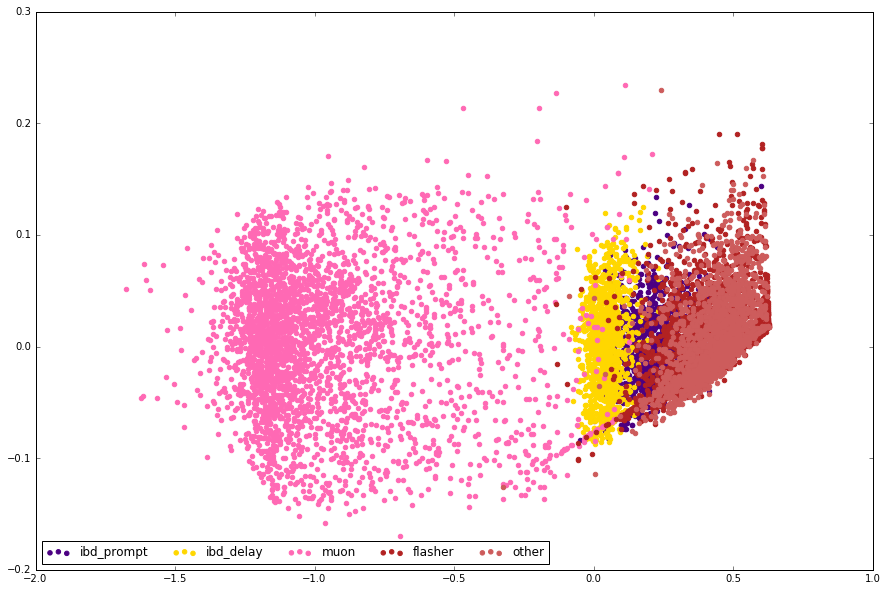

In [108]:
#plot the 2D-projection of the features
v.plot_features(x_pc,save=False)

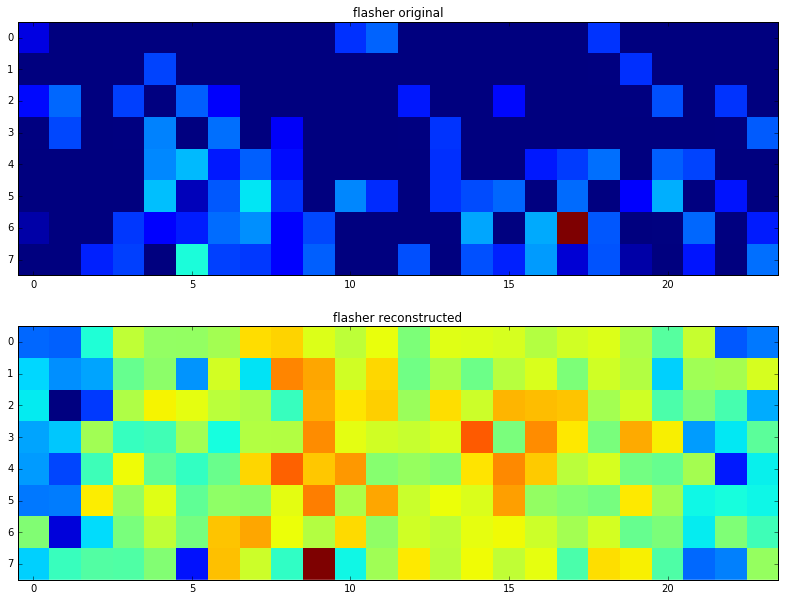

In [88]:
#get reconstruction of X_val from autoencoder
x_rec = cae.predict(X_val)

#fromat X_val
x_orig = X_val.reshape(X_val.shape[0], 192)

#plot reconstruction
v.plot_reconstruction(x_orig[2], x_rec[2], indx=10, save=False)